Trying out remove negatives on the finished SEDs.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d
from scipy.io.idl import readsav

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from specutils import Spectrum1D
import specutils.manipulation

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [16]:
path = '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/'

In [17]:
specs = glob.glob('{}*var*'.format(path))
specs

['/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj649_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj1132_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj15a_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj163_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj674_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj676a_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj699_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj729_broadb

In [4]:
def remove_negatives(w, f, e):
    print(len(f))
    wo, fo, eo = w, f, e
    nz = len(fo[fo <=0.0])
    print(nz)
    while nz > 0:
        fn = []
        wn = []
        en = []
        inds = []
        for i in range(len(fo))[1:-1]:
            if fo[i] <= 0.0:
                inds.append(i-1)
                inds.append(i+1)
                weights = 1 / (eo[i-1:i+2]**2)
                fn.append(np.average(fo[i-1:i+2],weights=weights))
                wn.append(np.mean(wo[i-1:i+2]))
                en.append((1 / np.sum(weights, axis=0))**0.5)
            else:
                wn.append(wo[i])
                fn.append(fo[i])
                en.append(eo[i])
        inds = np.unique(inds)
        wn, fn, en = np.array(wn), np.array(fn), np.array(en)
        print(len(fn))
        wn, fn, en  = np.delete(wn, inds), np.delete(fn, inds), np.delete(en, inds)
        print(len(fn))
        nz = len(fn[fn <=0.0])
        wo, fo, eo =wn, fn, en
        print(nz)
    return(wn, fn, en)

In [5]:
stars = []


for j, spec in enumerate(specs[0:1]):
#     print(spec)
#     plt.figure(figsize = (4*len(doublets), 10))
#     gs = GridSpec(2, 4)
    data = fits.getdata(spec, 1)
    star = fits.getheader(spec)['TARGNAME']
    print(star)
    stars.append(star)
    w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
    wn, fn, en = remove_negatives(w, f, e)
    plt.plot(w[w< 4000], f[w< 4000])    
    plt.plot(wn[wn< 4000], fn[wn< 4000])
    plt.yscale('log')
    plt.show()
    

In [6]:
# stars = []


# doublets = np.array([[1238.821, 1242.804],[1334.524,1335.709],[1393.755,1402.77],[1548.201,1550.772]])
# all_lines = doublets.flatten()
# names = ['N\,v', 'C\,II', 'Si\,IV', 'C\,IV']
# # dv_guess = np.array(ref_dvs)*u.km/u.s

# for j, spec in enumerate(specs):
# #     print(spec)
#     plt.figure(figsize = (4*len(doublets), 10))
#     gs = GridSpec(2, 4)
#     data = fits.getdata(spec, 1)
#     star = fits.getheader(spec)['TARGNAME']
#     print(star)
#     stars.append(star)
#     w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
#     wn, fn, en = remove_negatives(w, f, e)
#     diffs = np.diff(wn[wn < 5700])
#     print('n ones', len(diffs[diffs >1]))
#     print('int og', np.trapz(f[w < 4000], w[w < 4000]))
#     print('int nw', np.trapz(fn[wn < 4000], wn[wn < 4000]))
    
#     # lines = line_list[(line_list['Likelihood to measure'] == 'High') | (line_list['Likelihood to measure'] == 'Medium')]['Wavelength']

#     smooth =7 


#     for i, lines in enumerate(doublets):
# #         plt.subplot(1, len(doublets) , i+1)
#         plt.subplot(gs[0, i])
#         if i == 0:
#             plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# #         start, end = lines[0]-5, lines[1]+5
#         mask = (w >= lines[0]-7) & (w <= lines[1]+7)
#         maskn = (wn >= lines[0]-7) & (wn <= lines[1]+7)
#         if np.median(inst[mask]) in [1, 2, 16]:
#             mask = (w >= lines[0]-2) & (w <= lines[1]+2)
#             maskn = (wn >= lines[0]-2) & (wn <= lines[1]+2)
#         wi, fi, ei = w[mask], f[mask], e[mask]
#         wj, fj, ej = wn[maskn], fn[maskn], en[maskn]
#         if np.median(inst[mask]) in [1, 2]:
#             fi = convolve(fi,Box1DKernel(smooth))
#             ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5
#             fj = convolve(fj,Box1DKernel(smooth))
#             ej = convolve(ej,Box1DKernel(smooth))/smooth**0.5
# #         plt.errorbar(wi, fi, yerr =ei, errorevery=5)
# #         plt.errorbar(wj, fj, yerr =ej, errorevery=5)
#         plt.step(wi, fi, where='mid')
#         plt.step(wj, fj, where='mid')
        
#     #         print(std_guess)
    
#     plt.subplot(gs[1, :])
#     plt.plot(w[w< 4000], f[w< 4000])    
#     plt.plot(wn[wn< 4000], fn[wn< 4000])
#     plt.yscale('log')
#     plt.xlabel('Wavelength (\AA)')
    
#     plt.xlim(1100, 3000)
#     plt.tight_layout()
#     plt.subplots_adjust(wspace=0.2, hspace=0.1)
# #     plt.savefig('rv_plots/{}_rv.png'.format(star), dpi=150)
# #     plt.savefig('rv_plots/{}_rv.pdf'.format(star), dpi=150)
#     plt.show()
    
#     #     start += step


In [7]:
line_list = Table.read('../lines/all_linelist.csv')

In [8]:
lines = line_list[(line_list['Likelihood to measure'] == 'High')]['Wavelength']


In [9]:
line_groups = np.array([
    [1174.935,1175.265,1175.592,1175.713,1175.713,1175.989,1176.372],
    [1206.499],
    [1264.737,1265.001],
    [1238.821], 
    [1242.804],
    [1294.543],
    [1298.918],
    [1323.952],
    [1334.524],
    [1335.709],
    [1334.524,1335.709],
    [1393.755],
    [1402.77],
    [1548.201],
    [1550.772],
    [1640.332,1640.345,1640.375,1640.391,1640.474,1640.49,1640.533],
    [1657.268],
    [1656.267,1656.926,1657.008,1657.379,1657.907,1658.122],
    [1670.787],
    [2796.35], 
     [2803.53]], dtype='object')

In [10]:


def remove_negatives(w, f, e, grouped_lines, dv=0):
#     print(len(f))
    wo, fo, eo = w, f, e
   
    nz = len(fo[fo <0.0])
#     print(nz)
    while nz > 0:
        fn = []
        wn = []
        en = []
        inds = []
        mask = make_line_mask(wo, grouped_lines, dv=dv)
        wl, fl, el = wo[mask], fo[mask], eo[mask] #mask out lines in regions that you use to make average, but still check them for <0s
        for i in range(len(fo[1:-2])):
            if fo[i] < 0.0:
                inds.append(i-1)
                inds.append(i+1)
#                 weights = 1 / (eo[i-1:i+2]**2)
#                 fn.append(np.average(fo[i-1:i+2],weights=weights))
#                 wn.append(np.mean(wo[i-1:i+2]))
                weights = 1 / (el[i-1:i+2]**2)
#                 try:
#                     fn.append(np.average(fl[i-1:i+2],weights=weights))
#                 except:
#                     print('problem')
#                     print(wl[i-1:i+2],el[i-1:i+2])
                fn.append(np.mean(fl[i-1:i+2]))
                wn.append(np.mean(wo[i-1:i+2]))
                en.append((1 / np.sum(weights, axis=0))**0.5)
            else:
                wn.append(wo[i])
                fn.append(fo[i])
                en.append(eo[i])
        inds = np.unique(inds)
        inds = inds[np.argsort(inds)]
#         print(inds[-1])
        if inds[-1] == len(wn):
            inds = inds[:-2]
#         print(inds[-1])
        wn, fn, en = np.array(wn), np.array(fn), np.array(en)
#         print(len(fn))
        wn, fn, en  = np.delete(wn, inds), np.delete(fn, inds), np.delete(en, inds)
#         print(len(fn))
        nz = len(fn[fn <0.0])
        wo, fo, eo =wn, fn, en
#         print(nz)
    return(wn, fn, en)

def mask_maker(x, pairs, include=True):
    """
    creates a mask for a spectrum that excudes between pairs from an array
    """
    b = pairs[::2]
    r = pairs[1::2]
    C = np.zeros_like(x,dtype='bool')
    for i in range(len(b)):
        C |= (x>b[i])&(x<r[i])
    if include:
        return ~C
    else:
        return C

def make_line_mask(w, grouped_lines, dv=0): 
    """
    makes a list of wavelength ranges to cut
    """
    pairs = []
    for group in grouped_lines:
        group =  dv.to(u.AA, equivalencies=u.doppler_optical(group*u.AA)).value
        pairs.append(min(group)-0.5)    
        pairs.append(max(group)+0.5)
    mask = mask_maker(w, pairs)
    return mask

In [11]:
# print(stars)

In [12]:
stars = []

dvs = np.array([-3.2179626137386097,  40.08741304111106, -8.29172387532275, 36.44496578836573, 
       -8.496187662426907, -44.461822449302915, -124.3703158406861,12.180515773744279,
      -22.9621644919636, 16.10168084165221, 5.910544014529296,-62.558323075720324])*u.km/u.s


doublets = np.array([[1238.821, 1242.804],[1334.524,1335.709],[1393.755,1402.77],[1548.201,1550.772]])
all_lines = doublets.flatten()
names = ['N\,v', 'C\,II', 'Si\,IV', 'C\,IV']
# dv_guess = np.array(ref_dvs)*u.km/u.s

# for j, spec in enumerate(specs):
# #     print(spec)
#     plt.figure(figsize = (4*len(doublets), 10))
#     gs = GridSpec(2, 4)
#     data = fits.getdata(spec, 1)
#     star = fits.getheader(spec)['TARGNAME']
#     print(star)
#     stars.append(star)
#     w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
#     wn, fn, en = remove_negatives(w, f, e, line_groups, dv=dvs[j])
#     mask = make_line_mask(w, line_groups, dv=dvs[j])
#     wl, fl, el = w[mask], f[mask], e[mask]
#     diffs = np.diff(wn[wn < 5700])
#     print('n ones', len(diffs[diffs >1]))
#     print('int og', np.trapz(f[w < 4000], w[w < 4000]))
#     print('int nw', np.trapz(fn[wn < 4000], wn[wn < 4000]))
#     print('ratio', np.trapz(f[w < 4000], w[w < 4000])/np.trapz(fn[wn < 4000], wn[wn < 4000]))
    
#     # lines = line_list[(line_list['Likelihood to measure'] == 'High') | (line_list['Likelihood to measure'] == 'Medium')]['Wavelength']

#     smooth =7 


#     for i, lines in enumerate(doublets):
# #         plt.subplot(1, len(doublets) , i+1)
#         plt.subplot(gs[0, i])
#         if i == 0:
#             plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# #         start, end = lines[0]-5, lines[1]+5
#         mask = (w >= lines[0]-7) & (w <= lines[1]+7)
#         maskn = (wn >= lines[0]-7) & (wn <= lines[1]+7)
#         maskl = (wl >= lines[0]-7) & (wl <= lines[1]+7)
#         if np.median(inst[mask]) in [1, 2, 16]:
#             mask = (w >= lines[0]-2) & (w <= lines[1]+2)
#             maskn = (wn >= lines[0]-2) & (wn <= lines[1]+2)
#             maskl = (wl >= lines[0]-2) & (wl <= lines[1]+2)
            
#         wi, fi, ei = w[mask], f[mask], e[mask]
#         wj, fj, ej = wn[maskn], fn[maskn], en[maskn]
#         wk, fk, ek = wl[maskl], fl[maskl], el[maskl]
# #         if np.median(inst[mask]) in [1, 2]:
# #             fi = convolve(fi,Box1DKernel(smooth))
# #             ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5
# #             fj = convolve(fj,Box1DKernel(smooth))
# #             ej = convolve(ej,Box1DKernel(smooth))/smooth**0.5
# #             fk = convolve(fk,Box1DKernel(smooth))
# #             ek = convolve(ek,Box1DKernel(smooth))/smooth**0.5
# #         plt.errorbar(wi, fi, yerr =ei, errorevery=5)
# #         plt.errorbar(wj, fj, yerr =ej, errorevery=5)
#         plt.step(wi, fi, where='mid')
#         plt.step(wj, fj, where='mid')
# #         plt.step(wk, fk, where='mid')
        
#     #         print(std_guess)
    
#     plt.subplot(gs[1, :])
#     plt.plot(w[w< 4000], f[w< 4000])    
#     plt.plot(wn[wn< 4000], fn[wn< 4000])
#     plt.yscale('log')
#     plt.xlabel('Wavelength (\AA)')
    
#     plt.xlim(1100, 3000)
#     plt.tight_layout()
#     plt.subplots_adjust(wspace=0.2, hspace=0.1)
# #     plt.savefig('rv_plots/{}_rv.png'.format(star), dpi=150)
# #     plt.savefig('rv_plots/{}_rv.pdf'.format(star), dpi=150)
#     plt.show()
    
#     #     start += step


Let's make a fake spectrum and test it.

200
143
-0.6346400382798827
15
1.4522051505333846
13
nan


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


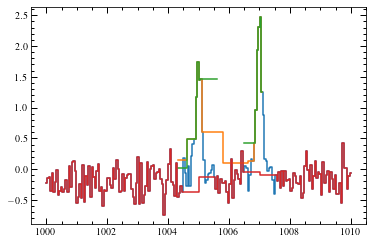

In [13]:

# Generate fake data
np.random.seed(41)
g1 = models.Gaussian1D(2, 1005, 0.1)
g2 = models.Gaussian1D(2.5, 1007, 0.1)
x = np.linspace(1000, 1010, 200)
y = g1(x) + g2(x)+ np.random.normal(-0.17, 0.2, x.shape)
z = np.random.normal(0., 0.2, x.shape)

plt.step(x, y, where='mid')
print(len(y))
print(len(y[y<0]))
print(np.trapz(y,x))
xn, yn, zn = remove_negatives(x, y, z,[[2000]], dv=0*u.km/u.s)

plt.step(xn, yn, where='mid')
print(len(xn))
print(np.trapz(yn,xn))



xn, yn, zn = remove_negatives(x, y, z,[[1005],[1007]], dv=0*u.km/u.s)

plt.step(xn, yn, where='mid')
print(len(xn))
print(np.trapz(yn,xn))


mask = make_line_mask(x, [[1005],[1007]], dv=0*u.km/u.s)
xl, yl, zl = x[mask], y[mask], z[mask]
plt.step(xl, yl, where='mid')

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


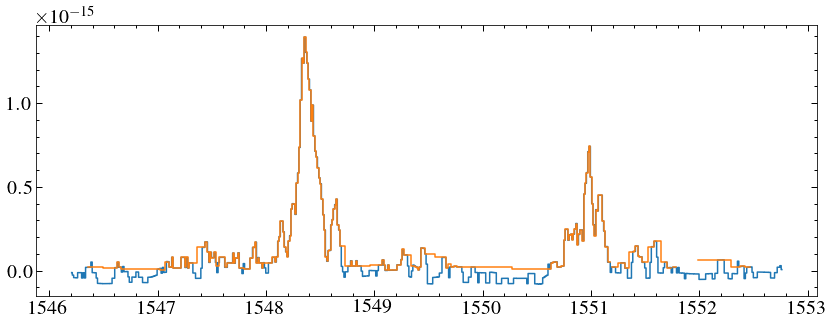

In [22]:
data = fits.getdata(specs[1])
w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
# wn, fn, en = remove_negatives(w, f, e, line_groups, dv=dvs[1])

lines = [1548.201,1550.772]
smooth = 5

#         start, end = lines[0]-5, lines[1]+5
# mask = (w >= lines[0]-7) & (w <= lines[1]+7)
# maskn = (wn >= lines[0]-7) & (wn <= lines[1]+7)
# if np.median(inst[mask]) in [1, 2, 16]:
mask = (w >= lines[0]-2) & (w <= lines[1]+2)
#     maskn = (wn >= lines[0]-2) & (wn <= lines[1]+2)

    
    
wi, fi, ei = w[mask], f[mask], e[mask]
fi = convolve(fi,Box1DKernel(smooth))
ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5
wj, fj, ej = remove_negatives(wi, fi, ei, line_groups, dv=dvs[1])

# wj, fj, ej = wn[maskn], fn[maskn], en[maskn]
# if np.median(inst[mask]) in [1, 2]:
#     fi = convolve(fi,Box1DKernel(smooth))
#     ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5
#     fj = convolve(fj,Box1DKernel(smooth))
#     ej = convolve(ej,Box1DKernel(smooth))/smooth**0.5

#         plt.errorbar(wi, fi, yerr =ei, errorevery=5)
#         plt.errorbar(wj, fj, yerr =ej, errorevery=5)
plt.step(wi, fi, where='mid')
plt.step(wj, fj, where='mid')

1.1543908117373161e-15
36768


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


1849
130
nan


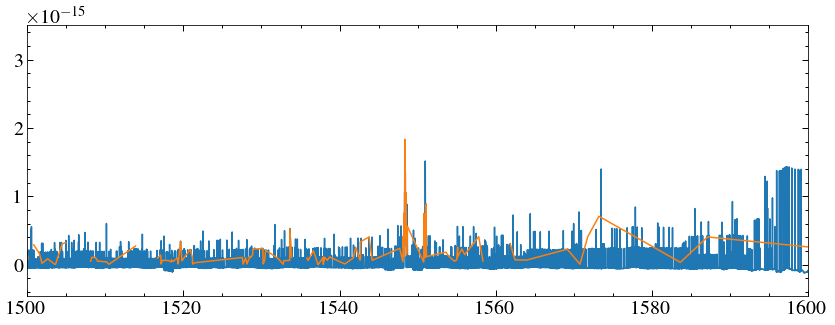

In [33]:
def make_no_negatives(data, line_groups=[[10000, 100001]], dv =0*u.km/u.s):
    """
    turn a MM data dictionary (i.e. one that already has all of the columns)
    """
    plt.plot(data['WAVELENGTH'], data['FLUX'])
    print(np.trapz(data['FLUX'], data['WAVELENGTH']))
    

    wn, fn, en = remove_negatives(data['WAVELENGTH'], data['FLUX'], data['ERROR'], line_groups, dv=dv)
    plt.plot(wn, fn)
    plt.xlim(1500, 1600)
    print(np.trapz(fn, wn))

# #     print(len(wn))
# #     print(np.diff(wn))
#     n = len(np.diff(wn)[np.diff(wn) > 1])
#     while n > 0: #iterativly adds the mean values in between points with dlambda > 1
# #         print(n)
#         w1, f1, e1 = wn, fn, en
#         for i in range(len(wn)-1):
#             if wn[i+1] - wn[i] > 1:
#                 weights = 1 / (en[i-1:i+2]**2)
#                 f1 = np.append(f1, np.average(fn[i-1:i+2],weights=weights))
#                 w1 = np.append(w1, np.mean(wn[i-1:i+2]))
#                 e1 = np.append(e1, (1 / np.sum(weights, axis=0))**0.5)
#         args = np.argsort(w1)
#         wn, fn, en = w1[args], f1[args], e1[args]
#         n = len(np.diff(wn)[np.diff(wn) > 1])
# #     plt.plot(wn, fn)
#     print(np.trapz(fn, wn))
    
def remove_negatives(w, f, e, grouped_lines, dv=0):
#     print(len(f))
    wo, fo, eo = w, f, e

    nz = len(fo[fo <0.0])
    #     print(nz)
    while nz > 0:
        print(nz)
        fn = []
        wn = []
        en = []
        inds = []
        mask = make_line_mask(wo, grouped_lines, dv=dv)
        wl, fl, el = wo[mask], fo[mask], eo[mask] #mask out lines in regions that you use to make average, but still check them for <0s 
        for i in range(len(fo[1:-2])):
            if fo[i] < 0.0:
                inds.append(i-1)
                inds.append(i+1)
    #                 weights = 1 / (eo[i-1:i+2]**2)
    #                 fn.append(np.average(fo[i-1:i+2],weights=weights))
    #                 wn.append(np.mean(wo[i-1:i+2]))
                weights = 1 / (el[i-1:i+2]**2)
    #                 try:
    #                     fn.append(np.average(fl[i-1:i+2],weights=weights))
    #                 except:
    #                     print('problem')
    #                     print(wl[i-1:i+2],el[i-1:i+2])
                fn.append(np.mean(fl[i-1:i+2]))
#                 if np.isnan(np.mean(fl[i-1:i+2])) == True:
#                     print('yes', wo[i], fl[i-1:i+2])
                wn.append(np.mean(wo[i-1:i+2]))
                en.append((1 / np.sum(weights, axis=0))**0.5)
            else:
                wn.append(wo[i])
                fn.append(fo[i])
                en.append(eo[i])
        inds = np.unique(inds)
        inds = inds[np.argsort(inds)]
    #         print(inds[-1])
        if inds[-1] == len(wn):
            inds = inds[:-2]
    #         print(inds[-1])
        wn, fn, en = np.array(wn), np.array(fn), np.array(en)
    #         print(len(fn))
        wn, fn, en  = np.delete(wn, inds), np.delete(fn, inds), np.delete(en, inds)
    #         print(len(fn))
        nz = len(fn[fn <0.0])
        wo, fo, eo =wn, fn, en
    #         print(nz)
    return(wn, fn, en)
                                       
tdata = data[(data['INSTRUMENT']== 1) & (data['ERROR'] != 0.0)] #just the COS spectrum

make_no_negatives(tdata, line_groups=line_groups, dv=dvs[1])

In [39]:
mpath = '../../stuff/muscles_eg/gj176/'
mspecs = glob.glob('{}*var*'.format(mpath))
mspecs
for mspec in mspecs:
    print(mspec)
    data = fits.getdata(mspec)
    data = data[data['INSTRUMENT'] ==1]
    w,f = data['WAVELENGTH'], data['FLUX']
#     plt.plot(w,f)
    print(np.trapz(f, w))

../../stuff/muscles_eg/gj176/hlsp_muscles_multi_multi_gj176_broadband_v22_var-res-sed.fits
5.244820220434018e-14
../../stuff/muscles_eg/gj176/hlsp_muscles_multi_multi_gj176_broadband_v22_adapt-var-res-sed.fits
5.5998441138624897e-14


In [ ]:
1.1543908117373161e-15/8.565200437884671e-14

In [40]:
5.244820220434018e-14/5.5998441138624897e-14

0.9366011113506526